<a href="https://colab.research.google.com/github/hamzafarooq/maven-blps-2/blob/main/Module%202/module_1_2_basic_llms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sentence Transformers are powerful encoders

In [73]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-mpnet-base-v2')

In [2]:
sentences = [
    "it caught him off guard that space smelled of seared steak",
    "she could not decide between painting her teeth or brushing her nails",
    "he thought there'd be sufficient time is he hid his watch",
    "the bees decided to have a mutiny against their queen",
    "the sign said there was road work ahead so she decided to speed up",
    "on a scale of one to ten, what's your favorite flavor of color?",
    "flying stinging insects rebelled in opposition to the matriarch"
]

len(sentences)

7

In [3]:
long_text = """
Comparing the cosine similarity scores, we see that by introducing the word "elephant" instead of "mouse" in Sentence 2, the cosine similarity score increased from approximately 0.856 (without noise) to approximately 0.898 (with noise).
This demonstrates how noise can affect the similarity measurement between sentences.
""".strip()

len(long_text)

321

In [4]:
# convert text into dense vectors
embeddings = model.encode(sentences)
embeddings.shape

(7, 768)

In [ ]:
#the bees decided to have a mutiny against their queen
#"flying stinging insects rebelled in opposition to the matriarch"

In [ ]:
# embeddings[0]

In [ ]:
# "it caught him off guard that space smelled of seared steak",


In [16]:
from sentence_transformers.util import cos_sim

scores = cos_sim(embeddings[0], embeddings[1:])

print(sentences[0])
for i, score in enumerate(scores[0]):
    print(f"{round(score.item(), 4):>6} | {sentences[i]}")

it caught him off guard that space smelled of seared steak
0.1293 | it caught him off guard that space smelled of seared steak
0.3083 | she could not decide between painting her teeth or brushing her nails
0.1389 | he thought there'd be sufficient time is he hid his watch
0.1416 | the bees decided to have a mutiny against their queen
 0.097 | the sign said there was road work ahead so she decided to speed up
0.1232 | on a scale of one to ten, what's your favorite flavor of color?


# Question Answering

In [75]:
from transformers import DPRContextEncoder, DPRContextEncoderTokenizer, DPRQuestionEncoder, DPRQuestionEncoderTokenizer

ctx_model = DPRContextEncoder.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')
ctx_tokenizer = DPRContextEncoderTokenizer.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')

question_model = DPRQuestionEncoder.from_pretrained('facebook/dpr-question_encoder-single-nq-base')
question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained('facebook/dpr-question_encoder-single-nq-base')

Some weights of the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRContextEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokeniz

In [18]:
questions = [
    "what is the capital city of australia?",
    "what is the best selling sci-fi book?",
    "how many searches are performed on Google?",
    "how many students are there in ML system design class?"
]

contexts = [
    "canberra is the capital city of australia",
    "what is the capital city of australia?",
    "the capital city of france is paris",
    "what is the best selling sci-fi book?",
    "sc-fi is a popular book genre read by millions",
    "the best-selling sci-fi book is dune"
    "Google serves more than 2 trillion queries annually",
    "Google is a popular search engine",
    "The number of students in ML System design class is 22"
]

In [20]:
xc_tokens = ctx_tokenizer(contexts, max_length=256, padding='max_length', truncation=True, return_tensors='pt')
xc = ctx_model(**xc_tokens)

xq_tokens = question_tokenizer(questions, max_length=256, padding='max_length', truncation=True, return_tensors='pt')
xq = question_model(**xq_tokens)

In [21]:
xc.pooler_output.shape, xq.pooler_output.shape

(torch.Size([8, 768]), torch.Size([4, 768]))

In [23]:
import torch

for i, xq_vec in enumerate(xq.pooler_output):
    probs = cos_sim(xq_vec, xc.pooler_output)
    argmax = torch.argmax(probs)
    print(questions[i])
    print(contexts[argmax])
    print('---')

what is the capital city of australia?
canberra is the capital city of australia
---
what is the best selling sci-fi book?
the best-selling sci-fi book is duneGoogle serves more than 2 trillion queries annually
---
how many searches are performed on Google?
Google is a popular search engine
---
how many students are there in ML system design class?
The number of students in ML System design class is 22
---


# Image-Text Embedding

In [26]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

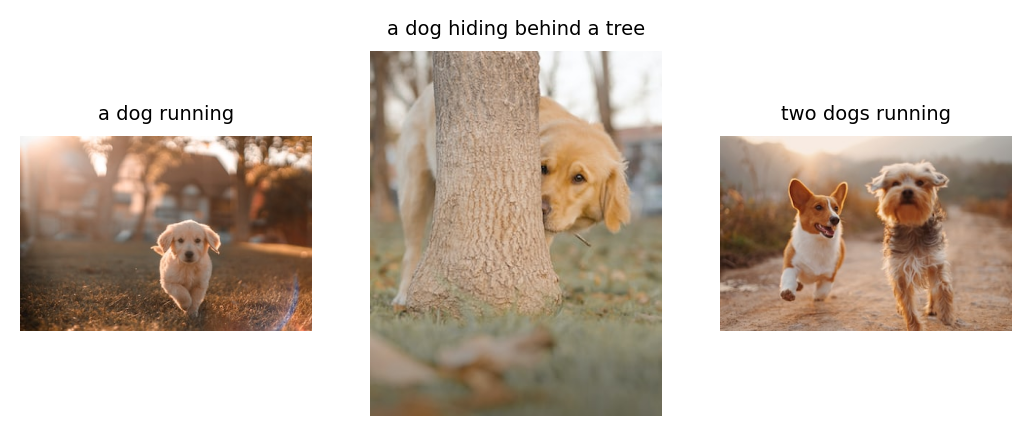

In [54]:
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import requests

urls = [
    "https://images.unsplash.com/photo-1576201836106-db1758fd1c97?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=400&q=80",
    "https://images.unsplash.com/photo-1591294100785-81d39c061468?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=300&q=80",
    "https://images.unsplash.com/photo-1548199973-03cce0bbc87b?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=400&q=80"
]

captions = [
    "a dog running",
    "a dog hiding behind a tree",
    "two dogs running"
]

images = [Image.open(requests.get(url, stream=True).raw) for url in urls]

# let's see what we have
fig, axs = plt.subplots(nrows=1, ncols=len(images), dpi=200)
for i in range(len(images)):
    axs[i].set_title(captions[i], fontsize=7)
    axs[i].imshow(images[i])
    axs[i].axis("off")

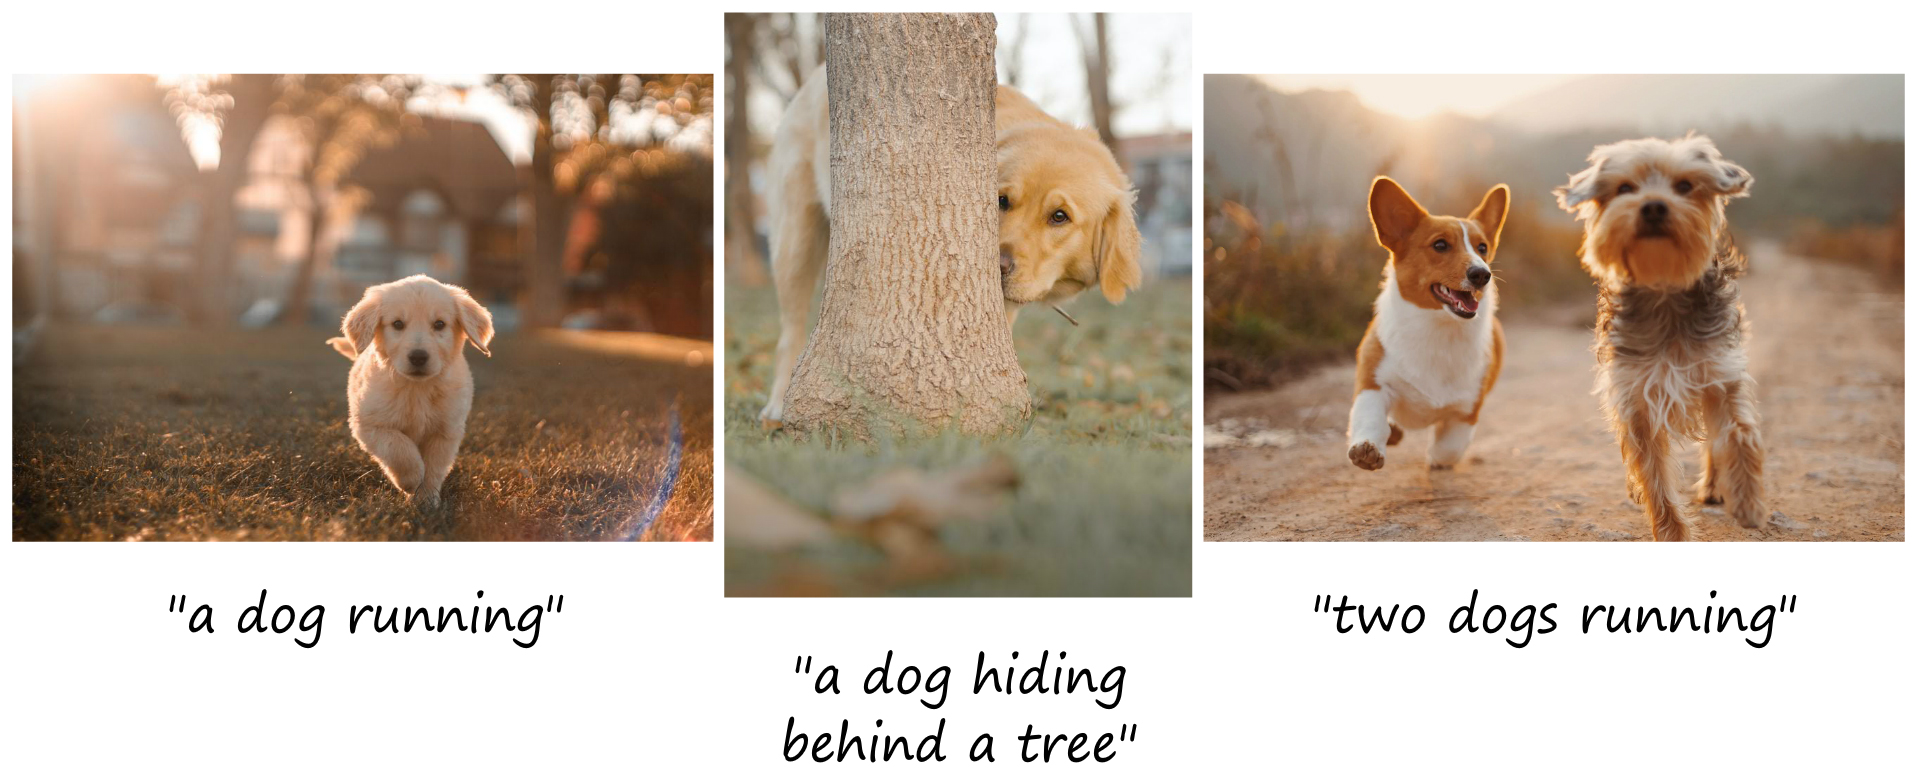

In [56]:
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32')
processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')

In [57]:
 captions = ["a dog hiding behind a tree",
            "two dogs running",
            "a dog running",
            "a cucumber on a tree",
            "trees in the park",
            "a cucumber dog"]

inputs = processor(text=captions, images=images, return_tensors='pt', padding=True)

outputs = model(**inputs)

probs = outputs.logits_per_image.argmax(dim=1)
probs

tensor([2, 0, 1])

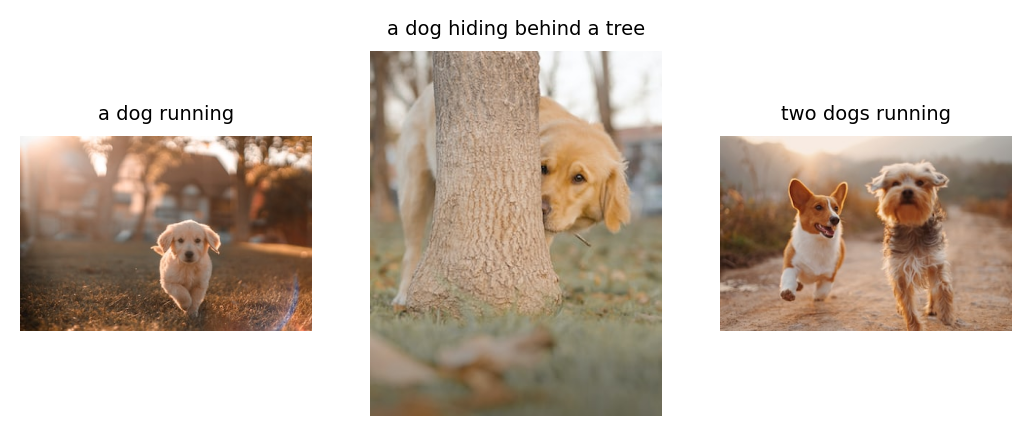

In [61]:
fig, axs = plt.subplots(nrows=1, ncols=len(images), dpi=200)

for i in range(len(images)):
    pred = captions[probs[i].item()]
    axs[i].set_title(pred, fontsize=7)
    axs[i].imshow(images[i])
    axs[i].axis("off")

plt.show()

In [62]:
# # requirements:
# ! pip install huggingface_hub accelerate
# ! git config --global credential.helper store

# Cosine Similarity

In [71]:
import numpy as np

def calculate_cosine_similarity(sentence1, sentence2):
    # Create a set of unique words from both sentences
    word_set = set(sentence1.split() + sentence2.split())

    # Create vectors representing the frequency of each word in each sentence
    vector1 = np.array([sentence1.split().count(word) for word in word_set])
    vector2 = np.array([sentence2.split().count(word) for word in word_set])

    # Calculate the dot product of the two vectors
    dot_product = np.dot(vector1, vector2)

    # Calculate the magnitude of each vector
    magnitude1 = np.linalg.norm(vector1)
    magnitude2 = np.linalg.norm(vector2)

    # Calculate the cosine similarity
    cosine_similarity = dot_product / (magnitude1 * magnitude2)

    return cosine_similarity

# Test the function
sentences = [
    "The cat chased the mouse.",
    "The cat chased the mouse in the garden.",
    "The mouse chased the elephant in the garden."
]

similarity_score = calculate_cosine_similarity(sentences[0], sentences[1])
print(f"The cosine similarity between the two sentences is: {similarity_score:.2%}")

The cosine similarity between the two sentences is: 70.71%


In [68]:
word_set = set(sentence1.split() + sentence2.split())
# word_set
vector1 = np.array([sentence1.split().count(word) for word in word_set])
print(vector1)

vector2 = np.array([sentence1.split().count(word) for word in word_set])
print(vector2)

vector3 = np.array([sentence1.split().count(word) for word in word_set])
print(vector3)

[1 0 1 0 1 1 1 0]
[1 0 1 0 1 1 1 0]
[1 0 1 0 1 1 1 0]


In [69]:
similarity_score = calculate_cosine_similarity(sentence2, sentence3)
print(f"The cosine similarity between the two sentences is: {similarity_score:.2%}")

The cosine similarity between the two sentences is: 90.00%


In [77]:
# convert text into dense vectors
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim

model = SentenceTransformer('all-mpnet-base-v2')
embeddings = model.encode(sentences)
print(embeddings.shape)



scores = cos_sim(embeddings[1], embeddings[2])

# print(sentences[0])
print(f"{round(score.item(), 4):>6} | {sentences[1]} | {sentences[2]}")

(3, 768)
0.8042 | The cat chased the mouse in the garden. | The mouse chased the elephant in the garden.


# Hugging Face APIs
Let’s look into how Hugging Face APIs can help generate text using LLMs like Bloom, Roberta-base, etc. First, we need to sign up for Hugging Face and copy the token for API access. After signup, hover over to the profile icon on the top right, click on settings, and then Access Tokens.

**Example 1: Sentence Completion**

Let’s look at how we can use Bloom for sentence completion. The code below uses the hugging face token for API to send an API call with the input text and appropriate parameters for getting the best response.

In [1]:
from huggingface_hub import notebook_login
from huggingface_hub import HfFolder


#enter your API key, you can make one for free on HF
notebook_login()

In [2]:
from huggingface_hub import InferenceApi

inference = InferenceApi("bigscience/bloom", token=HfFolder.get_token())

In [5]:
import time

def infer(prompt,
          max_length = 32,
          top_k = 0,
          num_beams = 0,
          no_repeat_ngram_size = 2,
          top_p = 0.9,
          seed=42,
          temperature=0.7,
          greedy_decoding = False,
          return_full_text = False):


    top_k = None if top_k == 0 else top_k
    do_sample = False if num_beams > 0 else not greedy_decoding
    num_beams = None if (greedy_decoding or num_beams == 0) else num_beams
    no_repeat_ngram_size = None if num_beams is None else no_repeat_ngram_size
    top_p = None if num_beams else top_p
    early_stopping = None if num_beams is None else num_beams > 0

    params = {
        "max_new_tokens": max_length,
        "top_k": top_k,
        "top_p": top_p,
        "temperature": temperature,
        "do_sample": do_sample,
        "seed": seed,
        "early_stopping":early_stopping,
        "no_repeat_ngram_size":no_repeat_ngram_size,
        "num_beams":num_beams,
        "return_full_text":return_full_text
    }

    s = time.time()
    response = inference(prompt, params=params)
    #print(response)
    proc_time = time.time() - s
    #print(f"Processing time was {proc_time} seconds")
    return response

In [6]:
from IPython.display import Markdown

prompt = "The thing that makes large language models interesting is"
resp = infer(prompt)[0]["generated_text"].strip()

Markdown(resp)

that they can be applied to many different kinds of problems, including speech recognition, translation, and generation. In particular, they can be used to improve the performance

In [12]:
import requests
from pprint import pprint

API_URL = 'https://api-inference.huggingface.co/models/bigscience/bloom'
def query(payload):
    response = requests.post(API_URL, json=payload)
    return response.json()

params = {'max_length': 200, 'top_k': 10, 'temperature': 2.5}
output = query({
    'inputs': 'Sherlock Holmes is a',
    'parameters': params,
})

Markdown(output[0]["generated_text"])

Sherlock Holmes is a great character, who is always in search of truth, who uses his intelligence for his personal benefit.

**Example 2: Question Answers**

We can use the API for the Roberta-base model which can be a source to refer to and reply to. Let’s change the payload to provide some information about myself and ask the model to answer questions based on that.

In [14]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline

model_name = "deepset/roberta-base-squad2"

# a) Get predictions
nlp = pipeline('question-answering', model=model_name, tokenizer=model_name)
QA_input = {
    'question': 'Why is model conversion important?',
    'context': 'The option to convert models between FARM and transformers gives freedom to the user and let people easily switch between frameworks.'
}
res = nlp(QA_input)
res

{'score': 0.21171391010284424,
 'start': 59,
 'end': 84,
 'answer': 'gives freedom to the user'}

In [17]:
import torch
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

# b) Load model & tokenizer
model = AutoModelForQuestionAnswering.from_pretrained(model_name, return_dict=False)
tokenizer = AutoTokenizer.from_pretrained(model_name)

text = "Huggingface has democratized NLP. Huge thanks to Huggingface for this."
question = "What has Huggingface done?"
encoding = tokenizer(question, text, return_tensors="pt")
input_ids = encoding["input_ids"] # Transform input tokens




# default is local attention everywhere
# the forward method will automatically set global attention on question tokens
attention_mask = encoding["attention_mask"]

start_scores, end_scores = model(input_ids, attention_mask=attention_mask)
all_tokens = tokenizer.convert_ids_to_tokens(input_ids[0].tolist())

answer_tokens = all_tokens[torch.argmax(start_scores) :torch.argmax(end_scores)+1]
answer = tokenizer.decode(tokenizer.convert_tokens_to_ids(answer_tokens)).strip()
Markdown(answer)

democratized NLP

**Example** 3: Summarization

We can summarize using Large Language Models. Let’s summarize a long text describing large language models using the Bart Large CNN model. We modify the API URL and added the input text below:

In [18]:
API_URL = "https://api-inference.huggingface.co/models/facebook/bart-large-cnn"

def query(payload):
    response = requests.post(API_URL, json=payload)
    return response.json()

params = {'do_sample': False}

full_text = """
AI applications are summarizing articles, writing stories and
engaging in long conversations — and large language models are doing
the heavy lifting.

A large language model, or LLM, is a deep learning model that can
understand, learn, summarize, translate, predict, and generate text and other
content based on knowledge gained from massive datasets.

Large language models - successful applications of
transformer models. They aren’t just for teaching AIs human languages,
but for understanding proteins, writing software code, and much, much more.

In addition to accelerating natural language processing applications —
like translation, chatbots, and AI assistants — large language models are
used in healthcare, software development, and use cases in many other fields.
""".strip()

output = query({
    'inputs': full_text,
    'parameters': params
})

Markdown(output[0]["summary_text"])

A large language model, or LLM, is a deep learning model that can understand, learn, summarize, translate, predict, and generate text. They aren’t just for teaching AIs human languages, but for understanding proteins, writing software code, and much more.

**Example 4**

Restart

In [ ]:
#@title Setup
# transformers_version = "v4.29.0" #@param ["main", "v4.29.0"] {allow-input: true}

# print(f"Setting up everything with transformers version {transformers_version}")

# !pip install huggingface_hub>=0.14.1 git+https://github.com/huggingface/transformers@$transformers_version -q diffusers accelerate datasets torch soundfile sentencepiece opencv-python openai

import IPython
import soundfile as sf

def play_audio(audio):
    sf.write("speech_converted.wav", audio.numpy(), samplerate=16000)
    return IPython.display.Audio("speech_converted.wav")

# from huggingface_hub import notebook_login
# notebook_login()

Setting up everything with transformers version v4.29.0


In [ ]:
from transformers import AutoProcessor, AutoModel


processor = AutoProcessor.from_pretrained("suno/bark")
model = AutoModel.from_pretrained("suno/bark").to("cuda")

inputs = processor(
    text=["Hello, my name is Suno. And, uh — and I like pizza. [laughs] But I also have other interests such as playing tic tac toe."],
    return_tensors="pt",
).to("cuda")

# speech_values = model.generate(**inputs, do_sample=True)

In [61]:
speech_values = model.generate(**inputs)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:10000 for open-end generation.


In [62]:
from IPython.display import Audio

sampling_rate = model.generation_config.sample_rate
Audio(speech_values.cpu().numpy().squeeze(), rate=sampling_rate)

In [ ]:
from IPython.display import Audio

sampling_rate = model.generation_config.sample_rate
Audio(speech_values.cpu().numpy().squeeze(), rate=sampling_rate)

In [25]:
from pathlib import Path
URL_BASE = Path("https://api-inference.huggingface.co/models")
URL_MODEL = URL_BASE / "bigcode/starcoder"
URL_MODEL

PosixPath('https:/api-inference.huggingface.co/models/bigcode/starcoder')

In [40]:
#@title Agent init
agent_name = "StarCoder (HF Token)" #@param ["StarCoder (HF Token)", "OpenAssistant (HF Token)", "OpenAI (API Key)"]

import getpass
from transformers.tools import HfAgent, OpenAiAgent

URL_BASE = "https://api-inference.huggingface.co/models/"


if agent_name == "StarCoder (HF Token)": 
    agent = HfAgent(str(URL_BASE + "bigcode/starcoder"))
    # agent = HfAgent("https://api-inference.huggingface.co/models/bigcode/starcoder")
    print("StarCoder is initialized 💪")
    
elif agent_name == "OpenAssistant (HF Token)":
    agent = HfAgent(URL_BASE + "OpenAssistant/oasst-sft-4-pythia-12b-epoch-3.5")
    print("OpenAssistant is initialized 💪")
    
elif agent_name == "OpenAI (API Key)":
    openai_apikey = getpass.getpass('OpenAI API key:')
    agent = OpenAiAgent(model="text-davinci-003", api_key=openai_apikey)
    print("OpenAI is initialized 💪")

StarCoder is initialized 💪


==Explanation from the agent==
I will use the following  tool: `image_generator` to generate an image.


==Code generated by the agent==
image = image_generator(prompt="a boat in the water")


==Result==


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/25 [00:00<?, ?it/s]

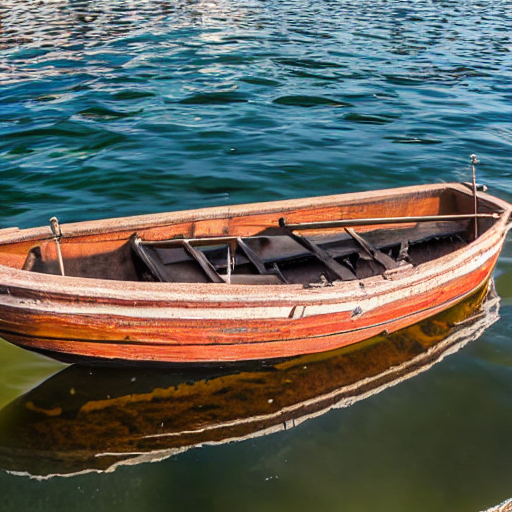

In [39]:
boat = agent.run("Generate an image of a boat in the water")
boat

==Explanation from the agent==
I will use the following  tools: `image_generator` to generate an image, then `image_transformer` to transform the image.


==Code generated by the agent==
image = image_generator(prompt="a man on mars riding a horse")
image = image_transformer(image=image, prompt="a man on mars riding a horse")


==Result==


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

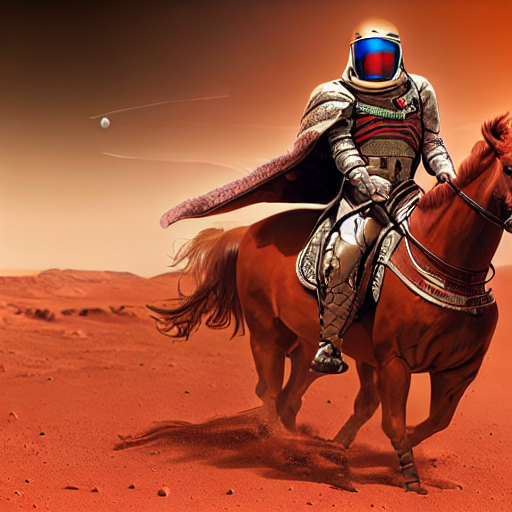

In [43]:
man_on_mars = agent.run("Generate an image of a man on mars riding a horse")
man_on_mars

In [45]:
import torch
from transformers import pipeline

generate_text = pipeline(
    model="databricks/dolly-v2-3b",
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
    device_map="auto"
)

In [46]:
res = generate_text("Explain to me the difference between nuclear fission and fusion.")
Markdown(res[0]["generated_text"])

Nuclear fission occurs when enough mass is struck by a heavy nucleus enough to split it apart, in order to produce a lower-energy nucleus and release energy in the form of part of its own mass (protons and neutrons) in the form of gamma rays. This releases much more energy than the original nucleus received.

Nuclear fusion occurs when two or more nuclei come too close together and share enough energy to overcome the barrier that prevents two nuclei from touching, in order to produce a higher energy nucleus and release energy in the form of gamma rays.